In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [30]:
from generation import FiguresDataset, id_to_cname, SIZE
from process import show_img, pick, sample

I've found a weird way to transform bounding boxes, labels (some of those may disappear) and images altogether in a same manner

In [42]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
tr_list = [A.Normalize((0, 0, 0), (0.5, 0.5, 0.5)), A.Resize(416, 416), ToTensorV2()]
tr = A.Compose(tr_list, bbox_params=A.BboxParams(format='yolo', label_fields=['cids'], min_visibility=0.5))

In [43]:
ds = FiguresDataset(transforms=tr)

10000 images and their descriptions have been loaded successfully


We've casted our dataset to torch.float tensors scaled to $[0,1]$ and normalized (sub mean div std), and their labels -- two lists containing normalized tuples $(xcenter, ycenter, width, height)$ and int class labels

In [44]:
ds[0][0].dtype, ds[0][1], ds[0][2], id_to_cname

(torch.float32,
 [(0.7578125, 0.5625, 0.11210937499999996, 0.11210937499999996),
  (0.1640625, 0.234375, 0.21820873325678614, 0.21820873325678614),
  (0.42578125, 0.5625, 0.1270889334026014, 0.12708893340260147)],
 [4, 1, 0],
 ['Circle', 'Rhombus', 'Rectangle', 'Triangle', 'Hexagon'])

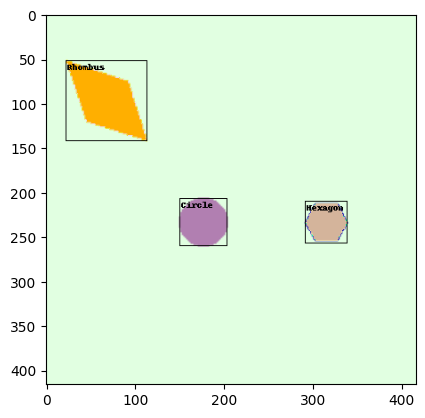

(None, [4, 1, 0])

In [45]:
show_img(pick(ds[0])), ds[0][2]

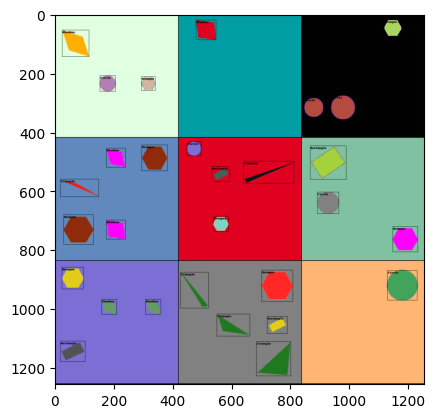

In [46]:
sample(ds)

YOLO is an agorithm that processes whole image in 1-pass manner using just convolutions

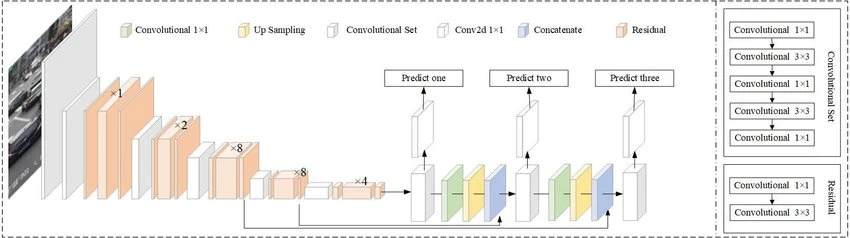

Our feature detector is somewhat typical, i.e. we stick to convolutional layers only, so that is FCN (but with bells and whistles), it outputs some feature map

But the classifier/regressor is 1x1 convolution over feature map, result is called cell map (same size) 

Each cell has to predict ONE object (=one of its bboxes) if its center falls into receiptive field

Suppose that a cell can predict a fixed amount of bounding boxes (B=3 for v3) and each of those tends to 'specialize' in detecting particular type of object (vertical human, horizontal car, square for the balooon)

Condition of each bbox is described by $5+C$ parameters:

- cx, cy - minimal vertex, pw, ph - dimensions for bounding box --> 4
- o - objectness score (confidence t) --> 1
- all class scores (conditional probability, implying o) --> C (number of classes, 5)

hence our feature detector should output a 3-tensor
$$C*H*W \rightarrow S*S*(B*(5+C))$$
where H=W and divisible by S

in fact, we don't output xywh boxes directly, instead we state 3 fixed 'anchors' i.e. pre-defined boxes $[cx, cy, pw, ph] \in R_{WH}$  controlled by 4 net output parameters $[tx,ty,tw,th]$ to fit ground truth bbox, aka log-space transform

\begin{split}
x = \sigma(tx) + \frac{cx}{W} \Rightarrow BB_x = x * W\\
y = \sigma(ty) + \frac{cy}{H} \Rightarrow BB_y = y * H\\
w = \frac{pw}{W}*e^{tw} \Rightarrow BB_w = w * W\\
h = \frac{ph}{H}*e^{th} \Rightarrow BB_h = h * H
\end{split}

Anchors are given before training, represent some prior knowledge about this dataset

They are generated using k-means clustering algorithm on all bboxes before training, (should be customized as our dataset is by no means similar to COCO)

Yolo performs detection on 3 scales, each requires 3 anchors => 9 in total

How to train:
let's create an S-grid on original image and match 1:1 to the cells from output
$$inp.cells \Leftrightarrow out.cells$$
Say, ic contains center of ob"ject's bbox, then corresponding oc is responsible for its detection

So, we choose an anchor with a highest IoU (with gt box), then tune up its parameters to get a better fit